# DSCI100 Group 5 Project Proposal
Group Members: Chengyuan Yao, Eunji Hwang, Lina Anwari, Duffy Du
# Title: 
# Table of Contents:
1. [Introduction](#introduction)
2. [Preliminary exploratory data analysis](#prelim-data)
3. [Methods](#methods)
4. [Expected outcomes and significance](#outcome-significance)


# 1.0 Introduction <a id='introduction'></a>

Heart disease is a leading cause of death globally and is linked to several factors such as obesity, smoking, and numerous more. For our classification model, we are using the Heart Disease Data Set, specifically the Cleveland database which contains information collected by Robert Detrano (M.D., Ph D.) from the Cleveland Clinic Foundation. It is based on anonymous real-life patients’ records and each row represents a report on a different patient based on the 14 categories. Our question is, is there a relationship that predicts the diagnosis of heart disease? (based on numerical variables below)

Heart Disease Data Set Variables/Descriptions:

1. age - age in years   
2. trestbps - resting blood pressure (in mm Hg on admission to hospital)  
3. chol - serum cholestoral in mg/dl  
4. thalach - maximum heart rate achieved
5. oldpeak - ST depression induced by exercise relative to rest


# <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.0 Preliminary Exploratory Data Analysis<a id='prelim-data'></a>

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
install.packages("expss")
library(expss)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.1 Reading and Checking data





In [3]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", 
                                         "sex", 
                                         "cp", 
                                         "trestbps", 
                                         "chol", 
                                         "fbs", 
                                         "restercg", 
                                         "thalach", 
                                         "exang", 
                                         "oldpeak", 
                                         "slope", 
                                         "ca", 
                                         "thal", 
                                         "num"))
cleveland_data$num <- as.factor(cleveland_data$num)
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restercg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [4]:
# see if there is other number rather than 0-4 in the num column
cleveland_data  %>%
    select(num)  %>% 
    unlist() %>% 
    levels()


[1] "0" "1" "2" "3" "4"

In [5]:
# transform num from 0-4 to 0 or 1 (1, 2, 3, 4) and store into diagnosis variable
cleveland_data <- cleveland_data %>%
                  mutate(diagnosis = dplyr::recode(num, '0' = 'absent', .default = 'present'))

head(cleveland_data)

age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,present
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,present
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,absent
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,absent


As the result we get correct data in the diagnosiscolumn

In [6]:
# to see how the original data distribute
cleveland_data %>% 
    group_by(diagnosis) %>%
    summarize(n = n())


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
absent,164
present,139


## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.2 Tidy the data

In [7]:
# We select all the numerical columns and diagnosis column
cleveland_data2 <- cleveland_data%>%
            select(age, trestbps, chol, thalach, oldpeak, diagnosis)
head(cleveland_data2)

age,trestbps,chol,thalach,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,absent
67,160,286,108,1.5,present
67,120,229,129,2.6,present
37,130,250,187,3.5,absent
41,130,204,172,1.4,absent
56,120,236,178,0.8,absent


In [8]:
# split the data into trainning and testing (ratio = 3:1)
set.seed(2344) 
cleveland_data_split<- initial_split(cleveland_data2, prop = 0.75, strata = diagnosis)  
cleveland_data_train<- training(cleveland_data_split)   
cleveland_data_test<- testing(cleveland_data_split)

In [9]:
# Summary statistics (max, min, mean, median and SD) of numerical variables
summary_data <-cleveland_data_train %>%
                apply_labels(age= "age",
                            trestbps = "trestbps",
                            chol = "chol",
                            thalach = "thalach",
                            oldpeak = "oldpeak")
                             
summary_table <- summary_data %>%
                 tab_cells(age, trestbps, chol, thalach, oldpeak) %>%
                 tab_cols(total(label = "Summary Statistics"))  %>%
                 tab_stat_fun(Max = w_max, Min = w_min, Mean = w_mean, "Median" = w_median, "Standand Deviation " = w_sd, method = list) %>%
                tab_pivot()
summary_table

|          | Summary Statistics |     |       |        |                     |
 |          |                Max | Min |  Mean | Median | Standand Deviation  |
 | -------- | ------------------ | --- | ----- | ------ | ------------------- |
 |      age |               77.0 |  29 |  54.3 |   55.0 |                 9.2 |
 | trestbps |              192.0 |  94 | 132.0 |  130.0 |                17.4 |
 |     chol |              564.0 | 131 | 247.1 |  240.0 |                52.8 |
 |  thalach |              202.0 |  71 | 149.8 |  154.0 |                23.5 |
 |  oldpeak |                5.6 |   0 |   1.0 |    0.6 |                 1.1 |

##  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3 Graphs of Relationships
 

    In this this section (2.3), we want to filter out the explanatory varibles we will be using to fit the model. An explanatory variable must meet both of the following 2 standards to be chosen as the explanatory variable in the model. 1. It must be independent from any other explanatory variables. 2. It must be related to the responsible variable (the diagnosis of heart disease). The reason for the first standard is that if an explanatory variable is related to another explanatory variable, then they can be expressed by each other so that taking both variables to fit the model is redundant. Therefore, we only need to keep one of the related variables. The reason for the second standard is that if the explanatory is not related to the responsible variable, then it is not explaining the responsible variable. If we fit such variable into the model, then the accuracy will be lowered. Therefore, we only choose the explanatory variables that are related to the responsible variable.
    In 2.3.1, we will be visualizing the graph that explanatory variables versus each other, so we can test for the standard 1. In 2.3.2, we will be visualizing each explanatory variable versus the respsonsible variable to test for the standard 2. The analysis and will be conducted in 2.3.3.
   

###  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.1 Graphs of Explanatory Variables Versus Each Other <a id='exp-exp'></a>

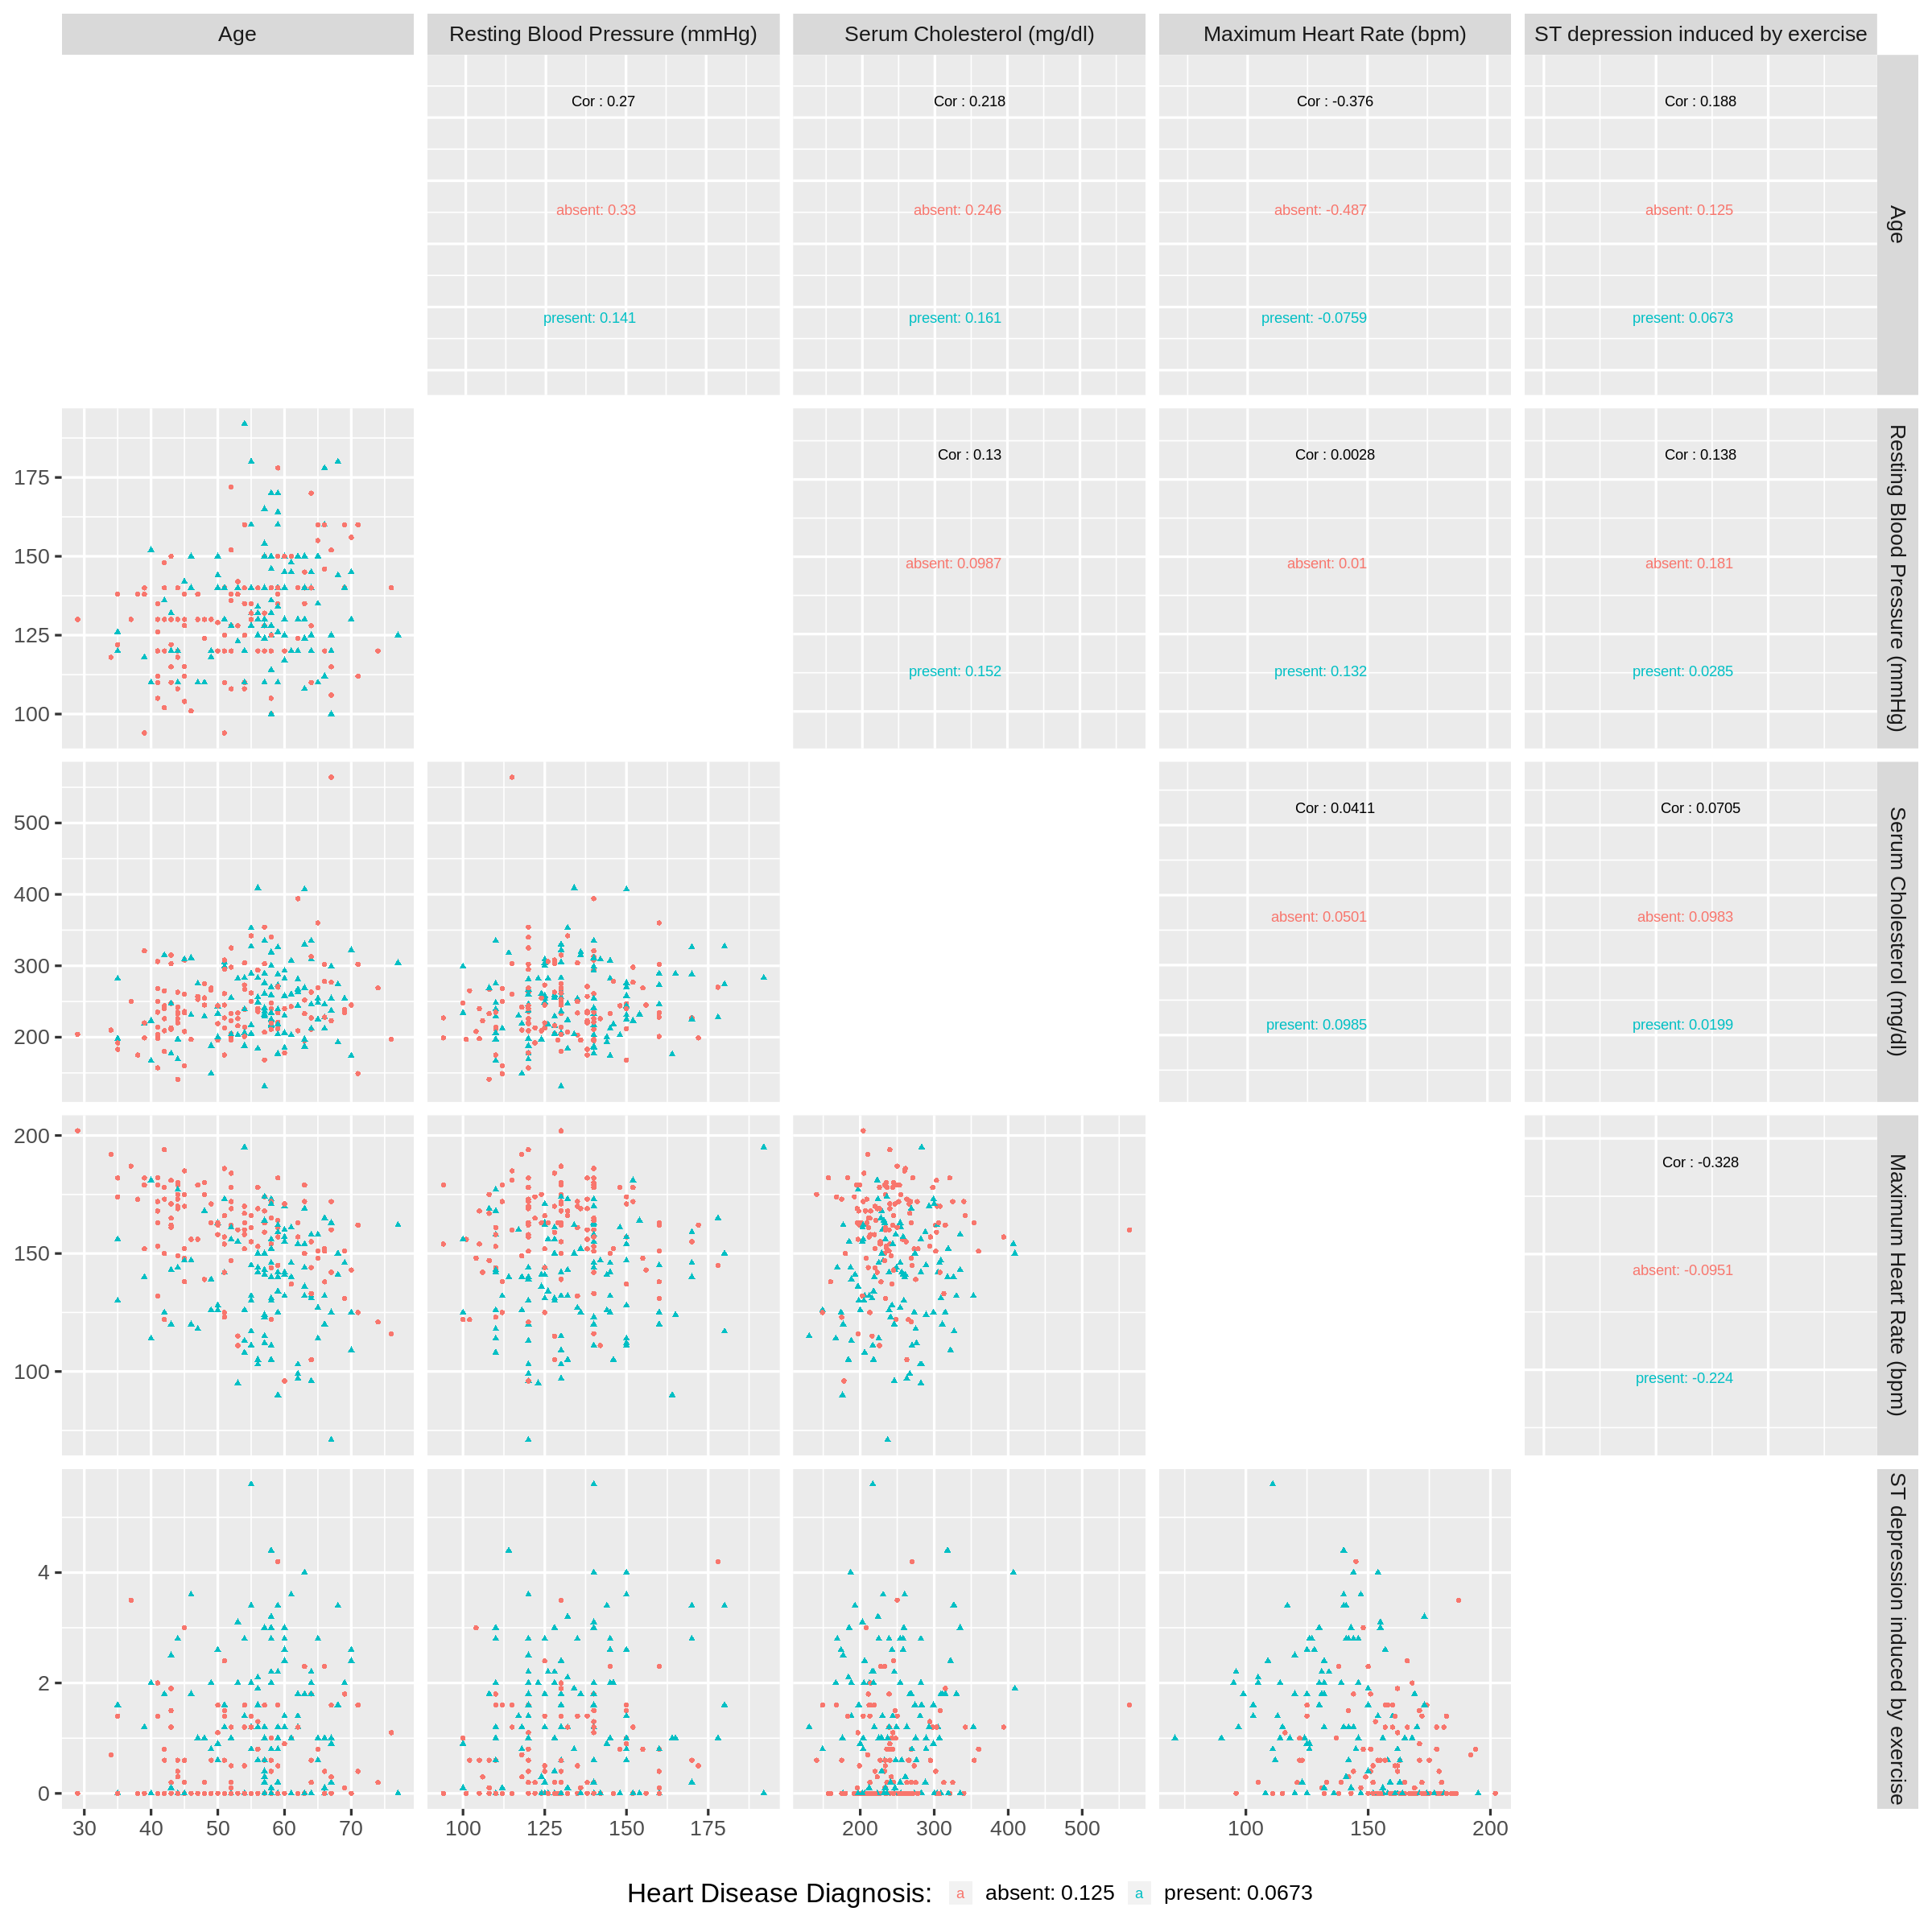

In [21]:
options(repr.plot.width = 20, repr.plot.height = 20) 

plot_pairs <- cleveland_data_train %>% 
  select(age, trestbps, chol, thalach, oldpeak, diagnosis) %>% 
  ggpairs(legend = 5,
          columns = 1:5,
          mapping = ggplot2::aes(color = diagnosis, shape = diagnosis),
          columnLabels = c("Age", "Resting Blood Pressure (mmHg)", "Serum Cholesterol (mg/dl)", "Maximum Heart Rate (bpm)", "ST depression induced by exercise"),
         diag = NULL) +
          labs(color = "Heart Disease Diagnosis: ") +
          theme(axis.text.x = element_text(hjust = 1, color = "black", size = 20),
                axis.text.y = element_text(hjust = 1, color = "black", size = 20)) +
          theme_grey(base_size = 20)+
          theme(legend.position = "bottom")  

plot_pairs

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2 Explanatory Variables vs. Heart Disease Diagnosis<a id='var-diag'></a>

[2.3.2.1 Age vs Heart Disease Diagnosis](#age-diag)  
[2.3.2.2 Resting Blood Pressure vs Heart Disease Diagnosis](#trestbps-diag)  
[2.3.2.3 Serum Cholestreol vs Heart Disease Diagnosis](#chol-diag)  
[2.3.2.4 Maximum Heart Rate vs Heart Disease Diagnosis](#thalch-diag)  
[2.3.2.5 ST Depression Induced by Exercise vs Heart Disease Diagnosis](#oldpeak-diag)  

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2.1 Graph of Age vs Heart Disease Diagnosis <a id='age-diag'></a>

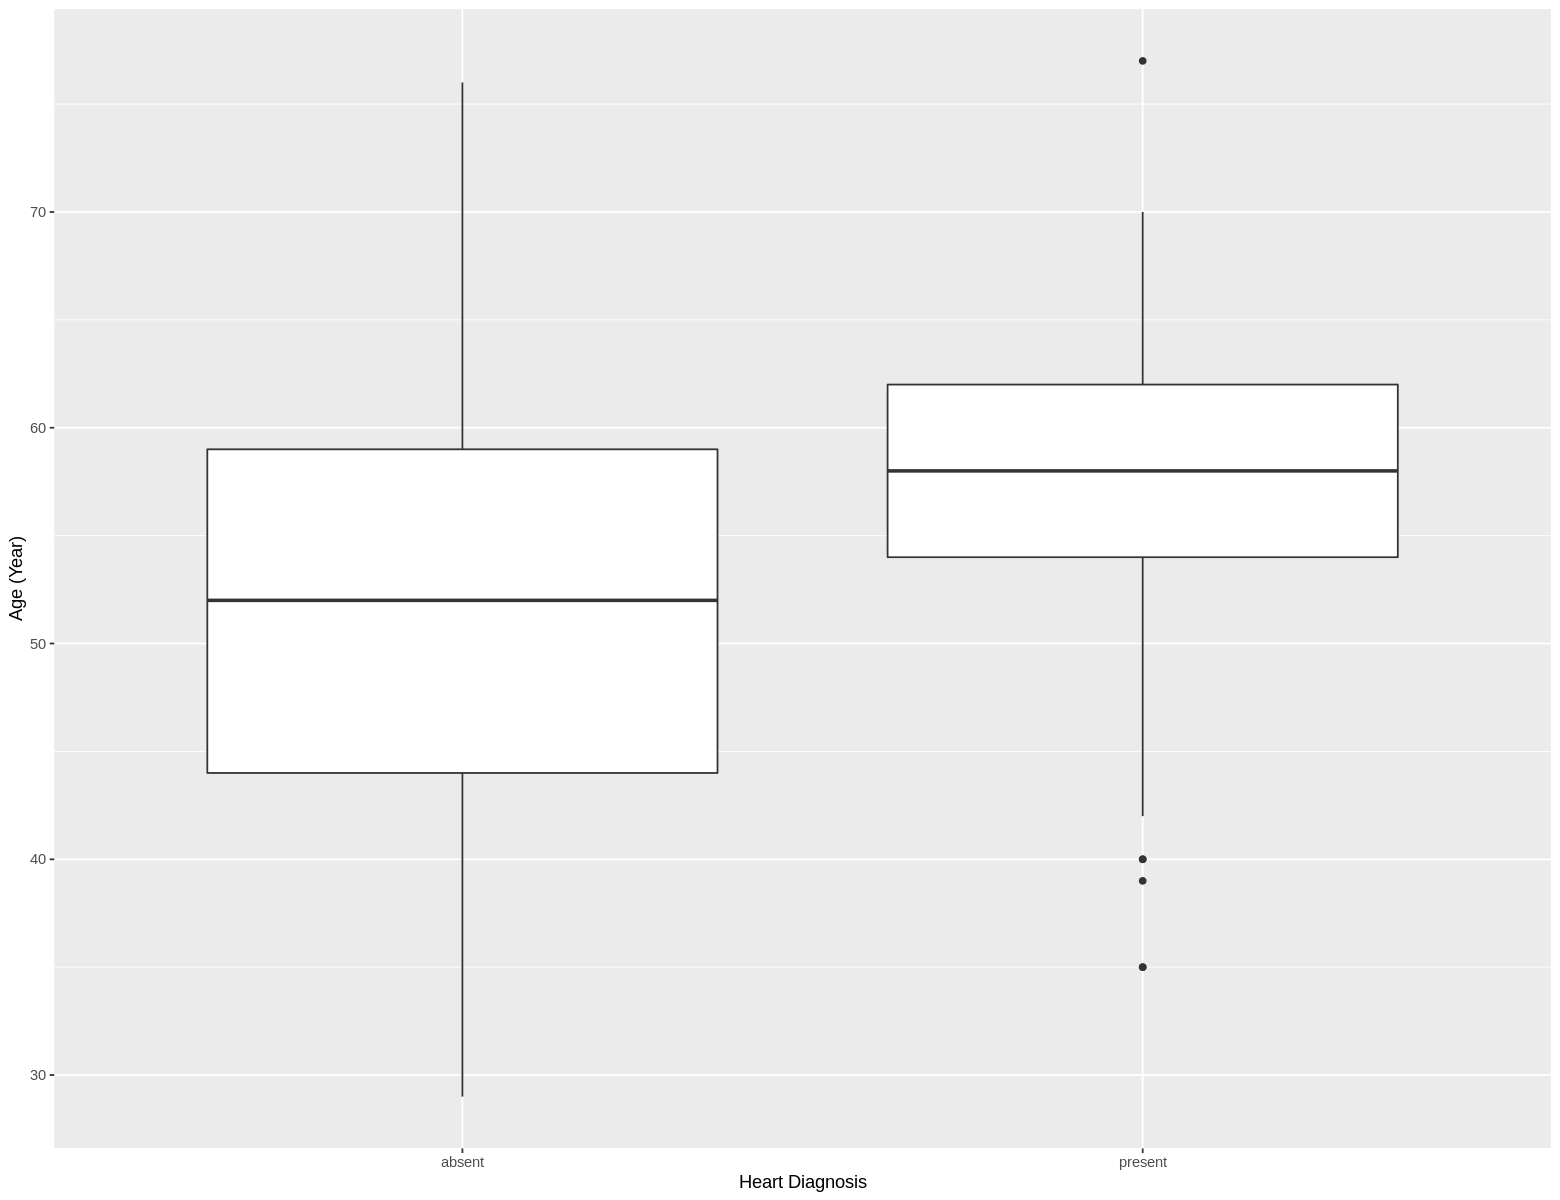

In [43]:
#age, trestbps, chol, thalach, oldpeak, diagnosis
options(repr.plot.width = 13, repr.plot.height = 10)
age_diag_plot <- ggplot(cleveland_data_train,aes(y=age,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Age (Year)")
age_diag_plot

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2.2 Graph of Resting Blood Pressure vs Heart Disease Diagnosis <a id='trestbps-diag'></a>

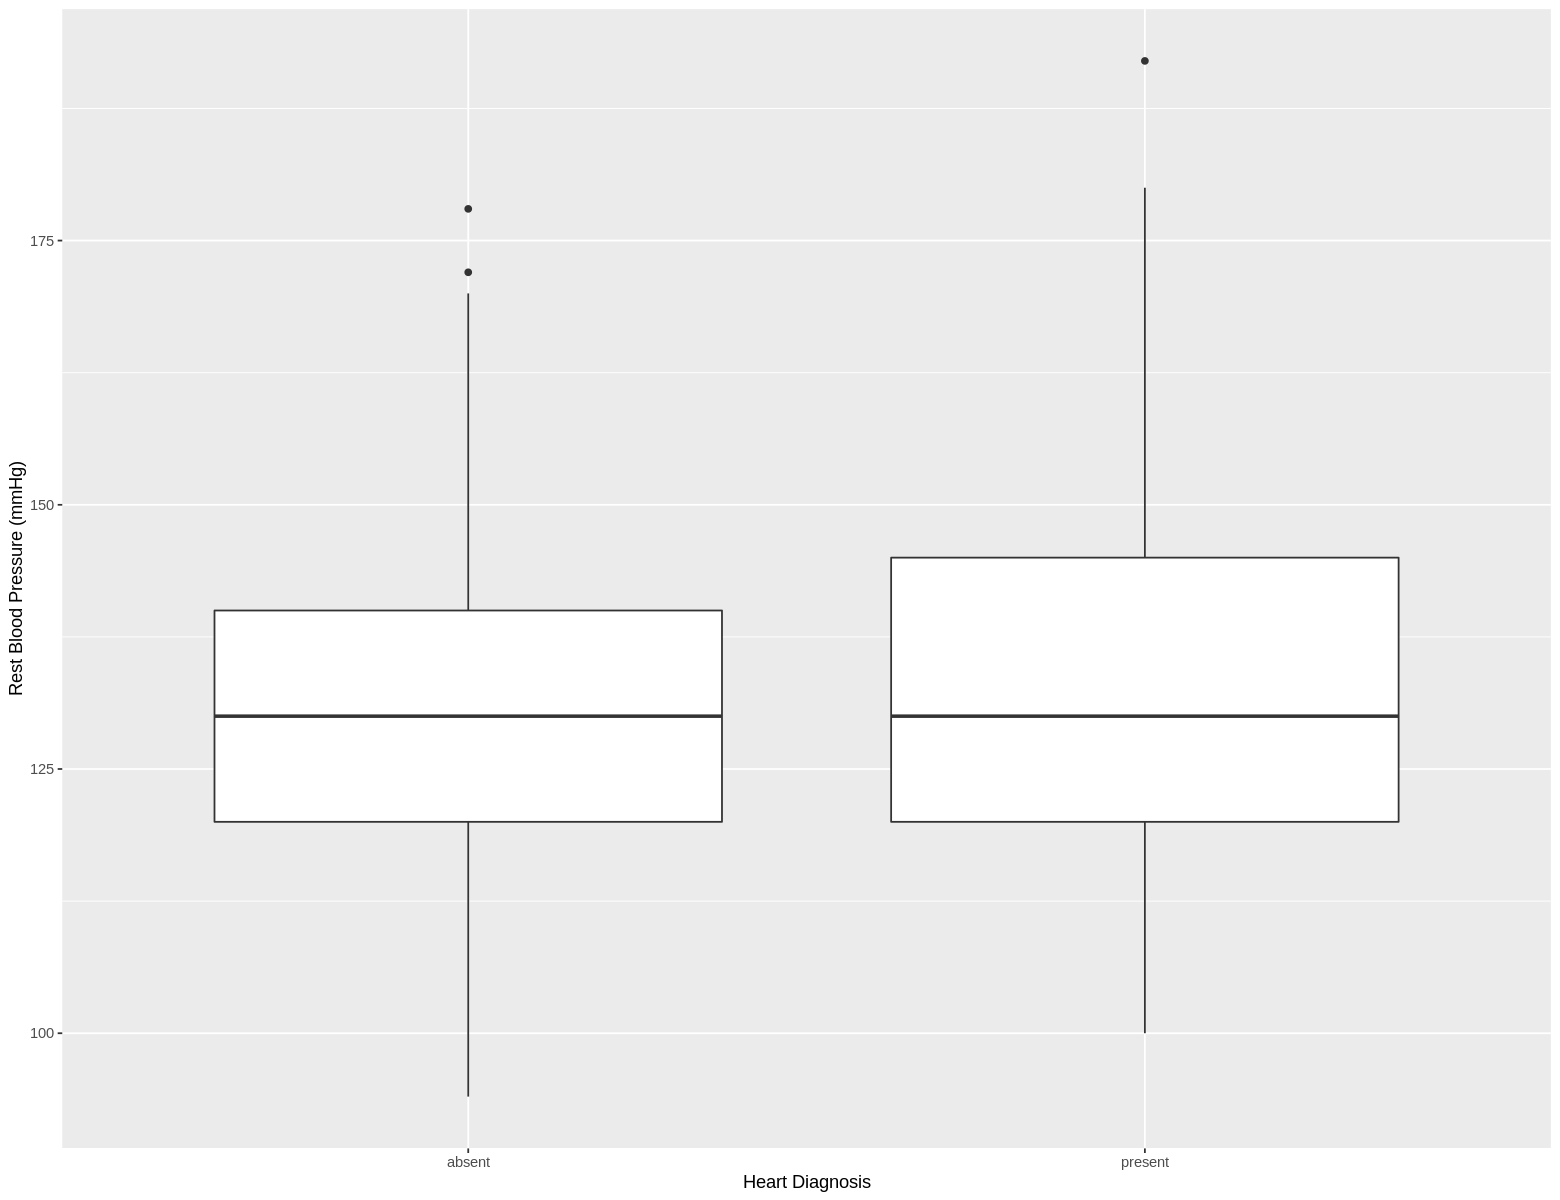

In [44]:
options(repr.plot.width = 13, repr.plot.height = 10)
trestbps_diag_plot <- ggplot(cleveland_data_train,aes(y=trestbps,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Rest Blood Pressure (mmHg)")
trestbps_diag_plot

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2.3 Graph of Serum Cholestrol vs Heart Disease Diagnosis <a id='chol-diag'></a>

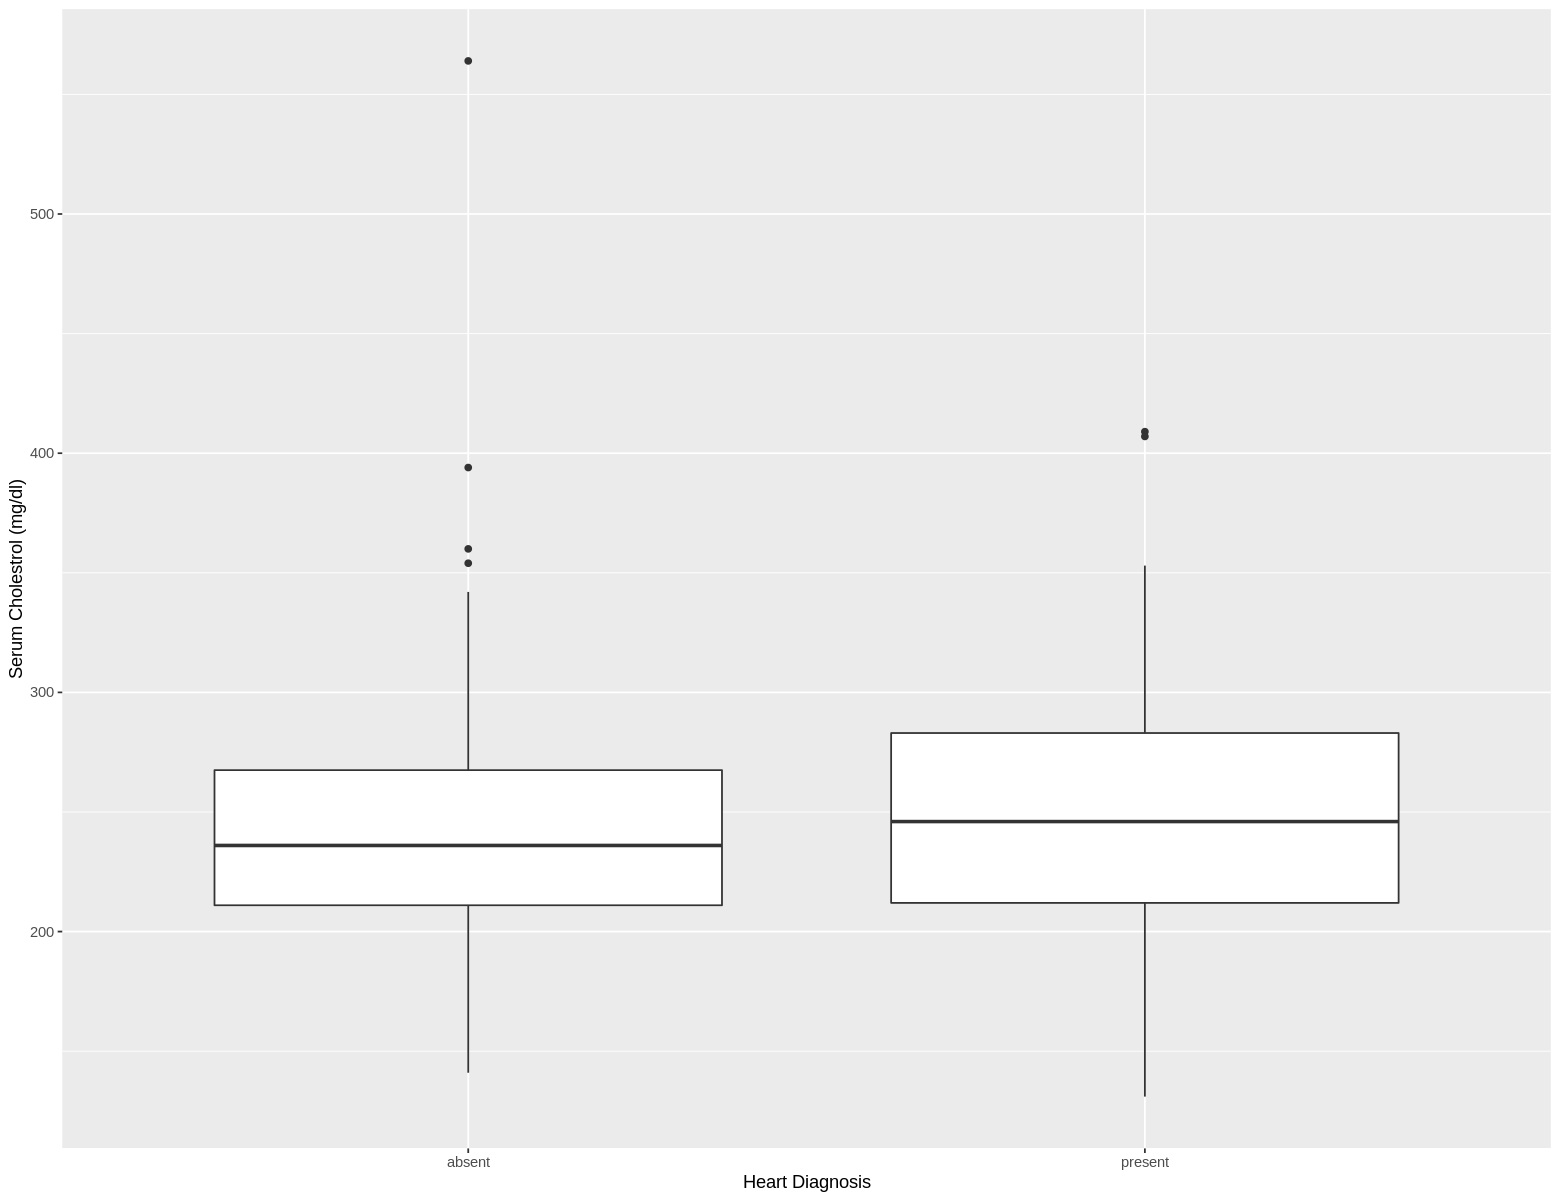

In [45]:
options(repr.plot.width = 13, repr.plot.height = 10)
chol_diag_plot <- ggplot(cleveland_data_train,aes(y=chol,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Serum Cholestrol (mg/dl)")
chol_diag_plot

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2.4 Graph of Maximum Heart Rate vs Heart Disease Diagnosis <a id='thalach-diag'></a>

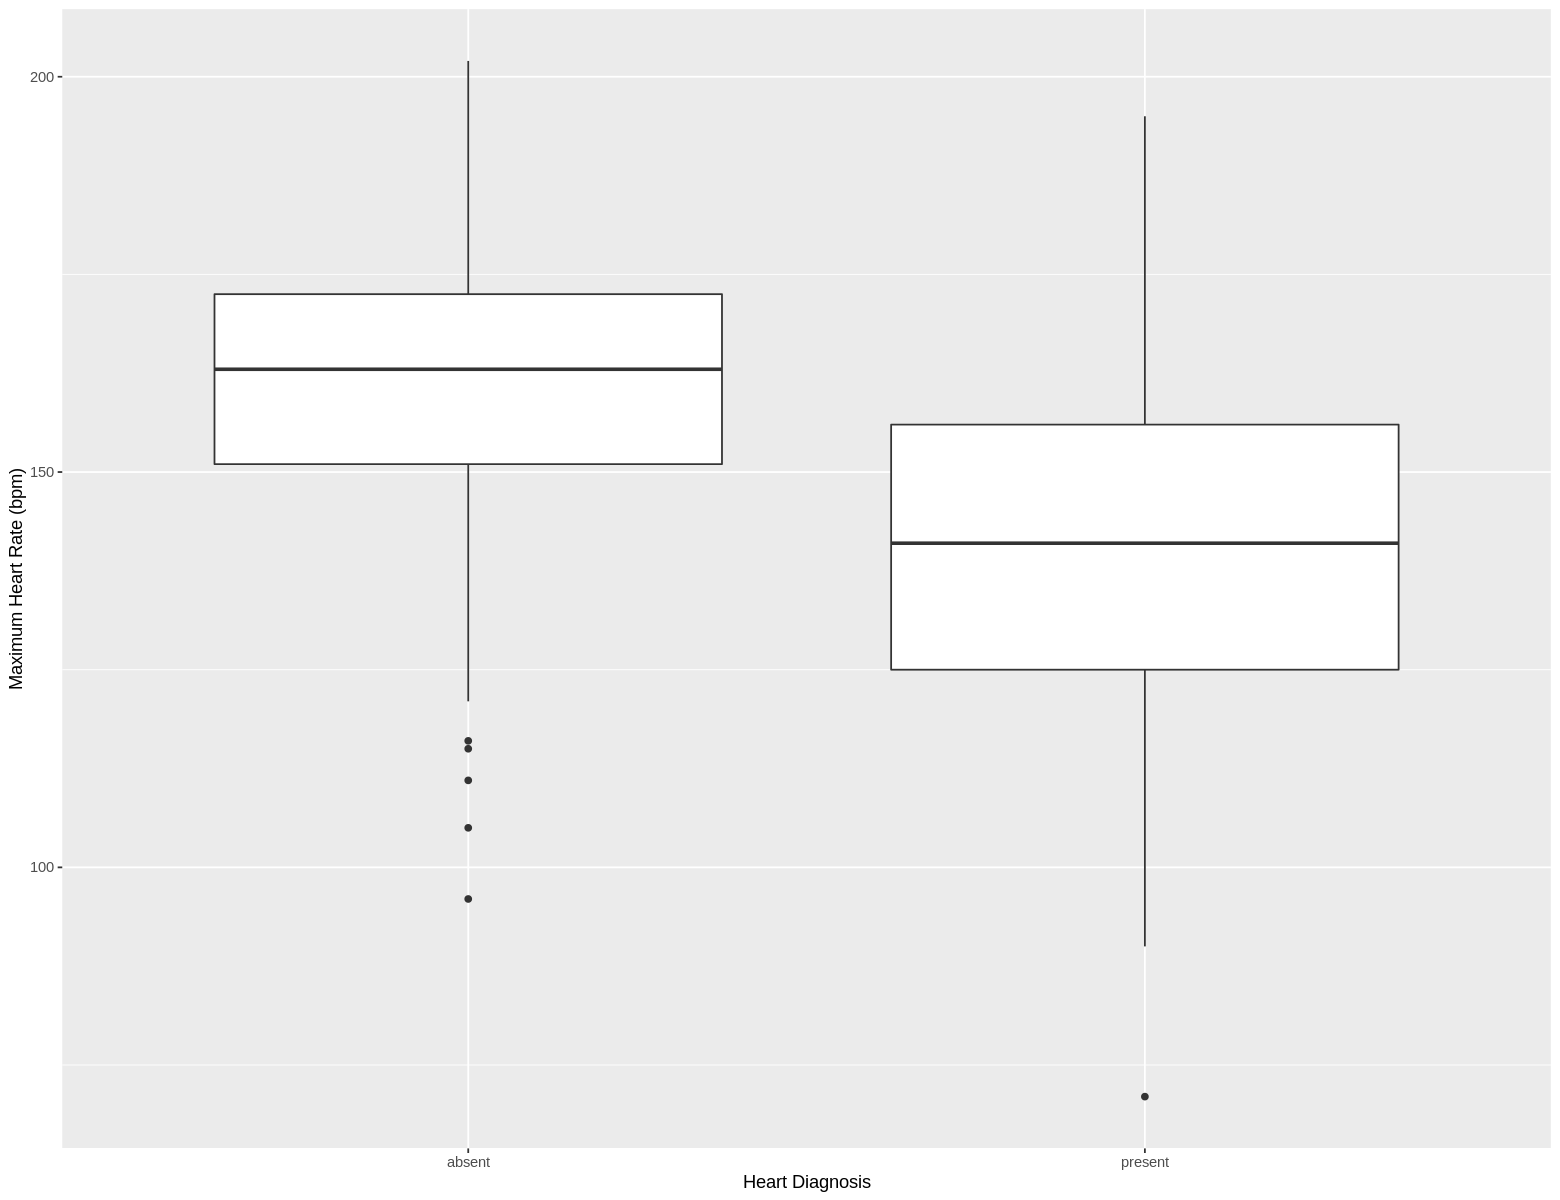

In [46]:
options(repr.plot.width = 13, repr.plot.height = 10)
thalach_diag_plot <- ggplot(cleveland_data_train,aes(y=thalach,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Maximum Heart Rate (bpm)")
thalach_diag_plot

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2.5 Graph of ST Depression Induced by Exercise vs Heart Disease Diagnosis <a id='oldpeak-diag'></a>

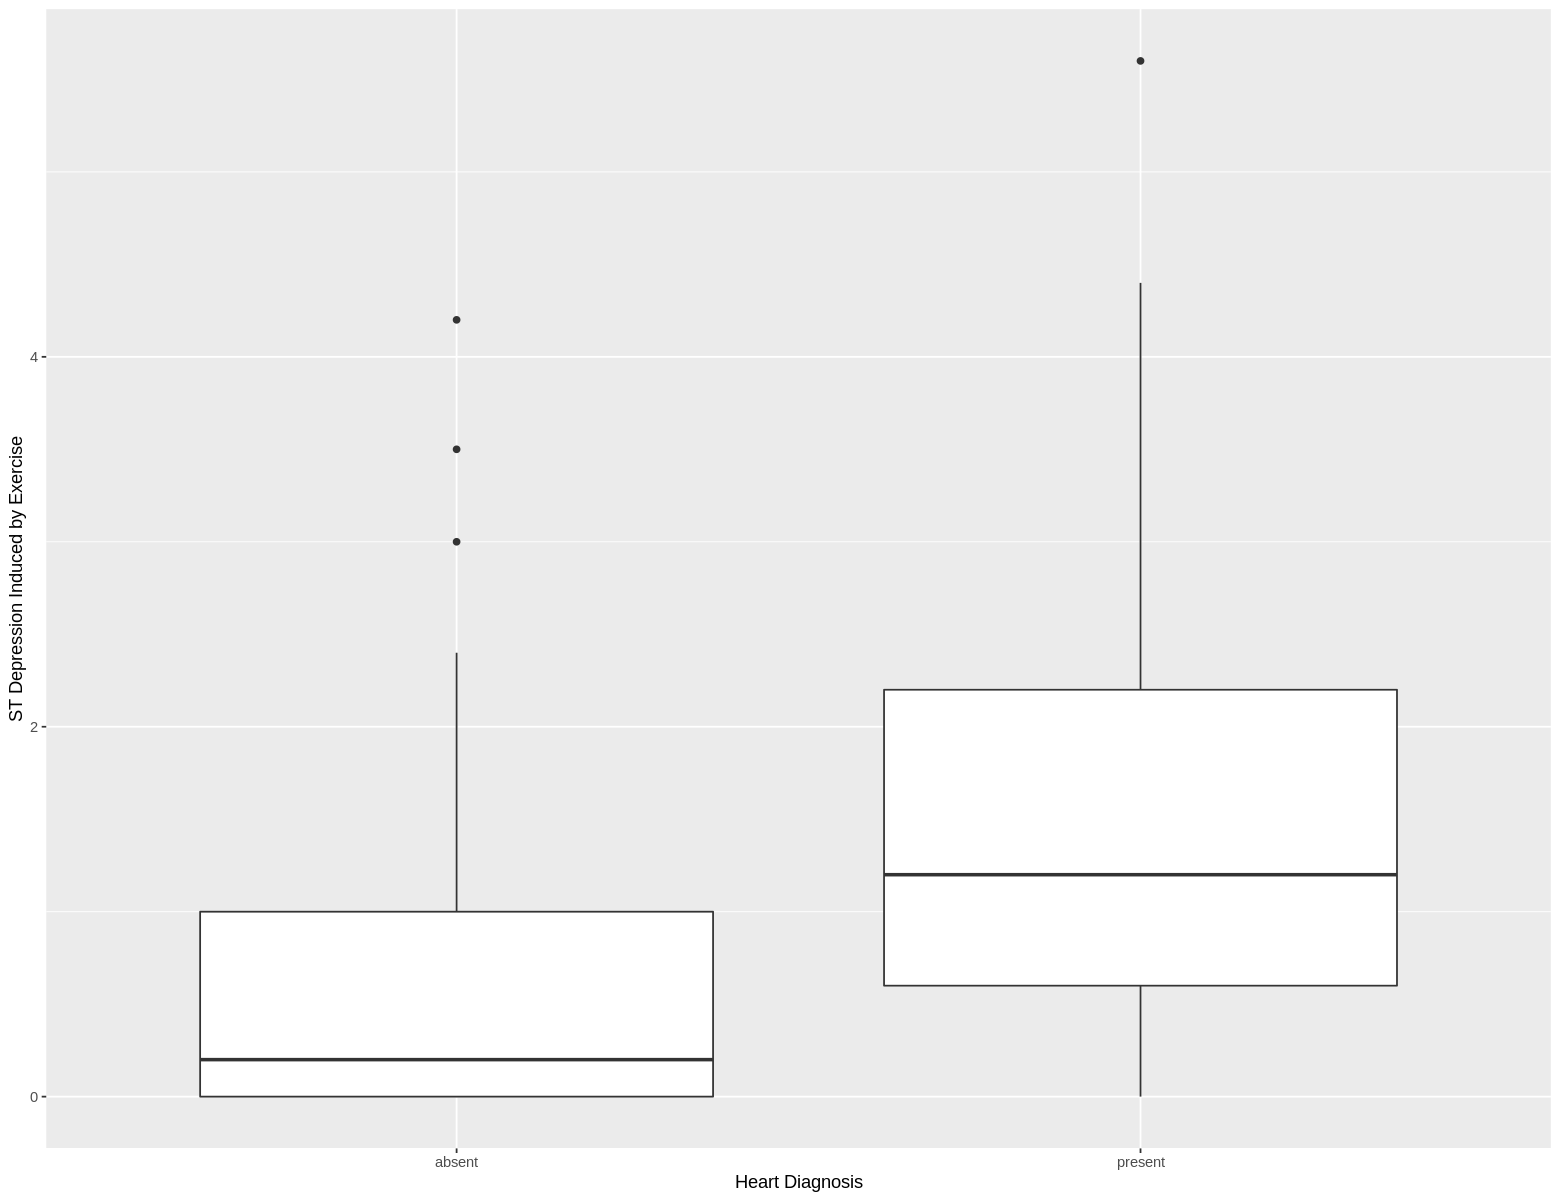

In [47]:
options(repr.plot.width = 13, repr.plot.height = 10)
oldpeak_diag_plot <- ggplot(cleveland_data_train,aes(y=oldpeak,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="ST Depression Induced by Exercise")
oldpeak_diag_plot

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.3 Analysis of Graphs<a id='analysis'></a>

As we can see from graph 2.3.1.2 to 2.3.1.3, there is clearly a positive relationship between Age and Serum Cholestrol, and a negative relationship between Age and Maximum Heart Rate; therefore, age can be expressed by a liner combination of Serum Cholestrol and Maximum Heart Rate (and potentially other variables), so that we will not choose the age as an explanatory variable for our model. Other graphs in 2.3.1 do not show a clear relationship between each other. In 2.3.2, we see that all explanatory variables are related to the Heart Disease Diagnosis since for each graph, we can see a significant difference in distribution of data points of each variable for absence or presence of the heart disease.
In conclusion, Resting Blood Pressure, Serum Cholestrol, Maximum Heart Rate, and ST Depression Induced by Exercise will be used as the explnatory variables in our model since they meet both of the standards we stated at the start of this section.

# 3.0 Methods <a id='methods'></a>

With the following key variables that seem to display a correlation with the heart disease, we will create a K nearest neighbour (KNN) classification model to predict heart disease:

- Serum Cholesterol 
- Maximum Heart Rate
- ST depression induced by exercise
- Resting Blood Pressure

Our KNN classification model will need to be trained, evaluated, and tuned with training and testing sets before predicting heart disease on a new patient. We will first split our training set to perform a five-fold cross-validation and find the appropriate value K for the KNN model by plotting K values against the accuracy scores. Then, we will use that KNN model to retrain our entire training data and check the accuracy on the testing dataset. We plan to analyze which combination of predictors will yield the lowest error resulting in a more effective model and visualize it with a scatter plot with two predictors on the x and y axes and colour data points with heart disease diagnosis.

# 4.0 Expected outcomes and significance <a id='outcome-significance'></a>

We expect to find that higher serum cholesterol and lower maximum heart rate increases likelihood of diagnosis with heart disease. Our classification model finds patterns that support prediction of heart disease in patients. Therefore, the impact our findings have is spreading awareness to signs of potential fatality to save lives. Future questions may dive deeper into additional factors influencing heart disease. It may indicate the invention of new technology because of the discovery which predicts one’s health based on this disease. Additionally, it could lead to questions that lead to new ways of prevention and allow for more opportunity for healthier lifestyles.